In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fibheap import FibonacciHeap as FibHeap
from peel_by_motif import *
import random, collections
from datetime import datetime
import pandas as pd
from compare_algs.greedy_algorithms import *
import itertools, os
from utils import *
import graph_tool.all as gt

In [2]:

plt.rcParams.update({'font.size': 14})

In [26]:
def summary(removed_nodes, G, node_mapping):
    ind = 0
    w = 0.3
    bins = [0, 1,4,10]
    bins += [i for i in range(20, 100, 20)]
    bins += [i for i in range(100, 600, 100)] +['inf']
    for subgraph in removed_nodes:
        sub_names = (get_key(node_mapping, subgraph))
        print(len(sub_names))
        print(sub_names)
        rates = nx.get_edge_attributes(G.subgraph(sub_names), "weight")
        value_list = list(rates.values())
        occ_nums = [choose_bin(i) for i in value_list]
        x = collections.Counter(occ_nums)
        num_occ = np.array([x[k] for k in range(13)])/sum([x[k] for k in range(13)])
        bar1 = plt.bar([i-w for i in range(13)], global_num_occ, width=w, color='r')
        bar2 = plt.bar([i for i in range(13)], num_occ, width=w, color='b')
        plt.xticks([i for i in range(13)], ['('+str(bins[i])+','+str(bins[i+1])+')' for i in range(13)], rotation=-60)
        plt.xlabel('Bins by edge weight')
        plt.ylabel('Percentage of edges')
#         plt.ylim(top=0.7)
        plt.legend([bar1, bar2], ['global dist', 'subgraph dist'])
        plt.tight_layout()
        plt.savefig('figs/enron/found'+str(ind)+'.png')
        plt.show()
        ind += 1
        print('end of this subgraph')

In [5]:
import re
import codecs

def parse_line(line):
    if len(line)<=1:
        return []
    if '<' in line:
        names = [re.sub(r" ?\([^)]+\)", "", n).strip(', \'"\n\r\t') for n in (re.findall("(.*?)\<.*?\>", line)) if len(n.strip(', \'"\n\r'))>1]
    else:
        names = [re.sub(r" ?\([^)]+\)", "", n).strip(', \'"\n\r\t') for n in line.split(',')]
    names = [n.split(', ')[1]+' '+n.split(', ')[0] if len(n.split(', '))==2 else n for n in names]
    return names

root = '/home/tianyi/Python_projects/anomaly_data/data/enron/maildir'

def recur(path):
    global all_mails, all_ccs, mess_ids
    for file in os.listdir(path):
        if os.path.isdir(path + '/' + file):
            recur(path + '/' + file)
        else:
            try:
                f = codecs.open(path + '/' + file, 'r', errors='ignore')
                cur_file_from = []
                cur_file_to = []
                cur_file_cc = []
                cur_file_date = ''
                flag = 0
                for line in f:
                    if line.startswith('Message-ID'):
                        if line.split(':')[1].strip() in mess_ids:
                            break
                        mess_ids.add(line.split(':')[1].strip())
                        flag += 1
                    if line.startswith('X-From:'):
                        cur_file_from = parse_line(line[8:])
                        if len(cur_file_from) == 0:
                            break
                        flag += 1
                    if line.startswith('X-To:'):
                        cur_file_to = parse_line(line[6:])
                        flag += 1
                    if line.startswith('X-cc:'):
                        cur_file_cc = parse_line(line[6:])
                        flag += 1
                    if line.startswith('Date:'):
                        cur_file_date = ' '.join(line[6:].split(' ')[1:4])
                        flag += 1
                    if flag >= 5:
                        break

                if len(cur_file_from)==0:
                    continue
                if len(cur_file_to)!=0:
                    all_mails.append((cur_file_from,cur_file_to, cur_file_date))
                if len(cur_file_cc)!=0:
                    all_ccs.append((cur_file_from,cur_file_cc, cur_file_date))
            except UnicodeDecodeError:
                continue

mess_ids = set()
all_mails = []
all_ccs = []
recur(root)
                    

In [6]:
mail_dict = dict()

for mail in all_mails:
    for sender in mail[0]:
        for receiver in mail[1]:
            if sender != receiver:
                if (sender, receiver) not in mail_dict:
                    mail_dict[(sender, receiver)] = 1
                else:
                    mail_dict[(sender, receiver)] += 1
                    
for mail in all_ccs:
    for sender in mail[0]:
        for receiver in mail[1]:
            if sender != receiver:
                if (sender, receiver) not in mail_dict:
                    mail_dict[(sender, receiver)] = 1
                else:
                    mail_dict[(sender, receiver)] += 1

In [7]:
G = nx.DiGraph()
edge_weights = []
for edge in mail_dict:
    edge_weights.append(mail_dict[edge])
    G.add_edge(edge[0],edge[1],weight=mail_dict[edge])

In [11]:
len(G.nodes), len(G.edges)

(101389, 374676)

In [10]:
f = open('input.txt', 'w')
for edge in G.edges:
    f.write(str(edge[0])+'\t'+str(edge[1])+'\t'+str(mail_dict[edge])+'\n')

In [12]:
# plt.hist(edge_weights)
edge_weights = np.array(edge_weights)
# edge_weights = edge_weights[edge_weights<2000]

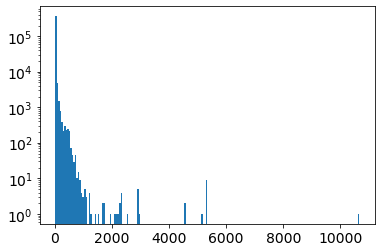

In [14]:
counts, _, _ = plt.hist(edge_weights, bins=200)
plt.yscale('log')

In [15]:
eps = 0.00001
occ_probs = (counts + eps)/sum(counts+eps)

In [21]:
sum(counts+eps), len(edge_weights[edge_weights==1]), len(edge_weights[edge_weights<5]), len(edge_weights[edge_weights>500])

(374647.0020000036, 100643, 255987, 378)

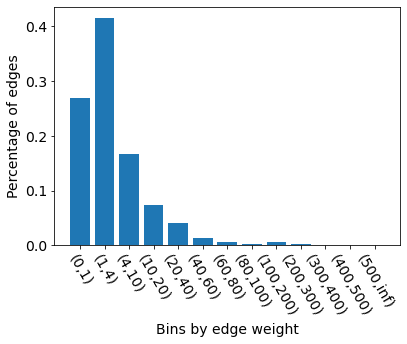

In [16]:
def choose_bin(value):
    bins = [1,4,10]
    bins += [i for i in range(20, 100, 20)]
    bins += [i for i in range(100, 600, 100)] + [20000]
    for i in range(len(bins)):
        if value<=bins[i]:
            return i
        
bins = [0, 1,4,10]
bins += [i for i in range(20, 100, 20)]
bins += [i for i in range(100, 600, 100)] +['inf']
occ_nums = [choose_bin(i) for i in edge_weights]
x = collections.Counter(occ_nums)
global_num_occ = np.array([x[k] for k in range(len(x))])/sum([x[k] for k in range(len(x))])
plt.figure(figsize=(6,5))
plt.bar([i for i in range(len(x))], global_num_occ)
plt.xticks([i for i in range(len(x))], ['('+str(bins[i])+','+str(bins[i+1])+')' for i in range(len(x))], rotation=-60)
plt.xlabel('Bins by edge weight')
plt.ylabel('Percentage of edges')
# plt.yscale('log')
plt.tight_layout()
plt.savefig('figs/enron/dist.png')

In [17]:
nodes = set(G.nodes)
node_mapping = {}
node_ind = 0
for node in nodes:
    node_mapping[node] = node_ind
    node_ind += 1
num_nodes = len(nodes)
edges = [(node_mapping[edge[0]], node_mapping[edge[1]], choose_bin(G[edge[0]][edge[1]]['weight'])) for edge in G.edges]

In [19]:
node_chisquares = node_chisquare(edges, num_nodes, global_num_occ, adjust_idx=0)
removed_nodes = several_peel_weighted(edges, node_chisquares, peel_times=5, log=False)

3
['Cheryl Johnson', 'Rhonda L Denton', 'Veronica Espinoza']


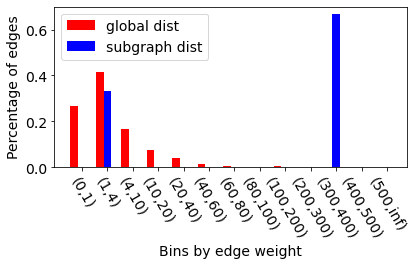

end of this subgraph
5
['Tamara Jae Black', 'Rhonda L. Denton', 'David Forster', 'Stephen R. Harrington', 'Enron Center South Technology']


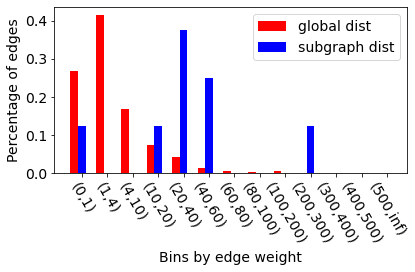

end of this subgraph
7
['@ENRON', 'Linda J Noske', 'Ginger Dernehl', 'Scott Govenar', 'Susan J Mara', 'Miyung Buster', 'Jeff Dasovich']


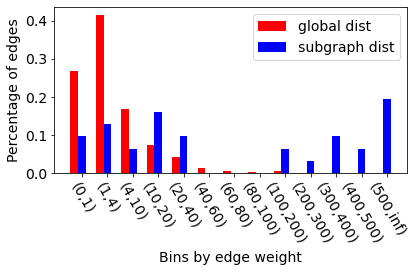

end of this subgraph
19
['Outlook Migration Team', 'Leonardo Pacheco', 'Jeff Skilling', 'Neil Davies', 'Katherine Brown', 'Pete Davis', 'Liz Taylor', 'Julie Clyatt', 'Bob Ambrocik', 'Sally Beck', 'Fraisy George', 'Schedule Crawler', 'Simone La rose', 'Steven J Kean', 'Janette Elbertson', 'Iris Mack', 'Rosalee Fleming', 'David Oxley', 'Kenneth Lay']


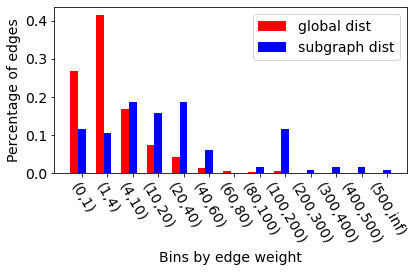

end of this subgraph
2
['Lorna Brennan', 'Janet Butler']


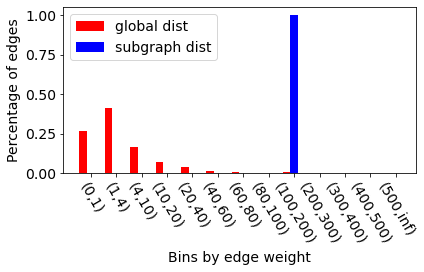

end of this subgraph


In [27]:



summary(removed_nodes, G, node_mapping)

sally beck: Chief Operating Officer
Steven J Kean: senior Vice President of Government Affairs.
Rosalee Fleming: assistant of Kenneth Lay

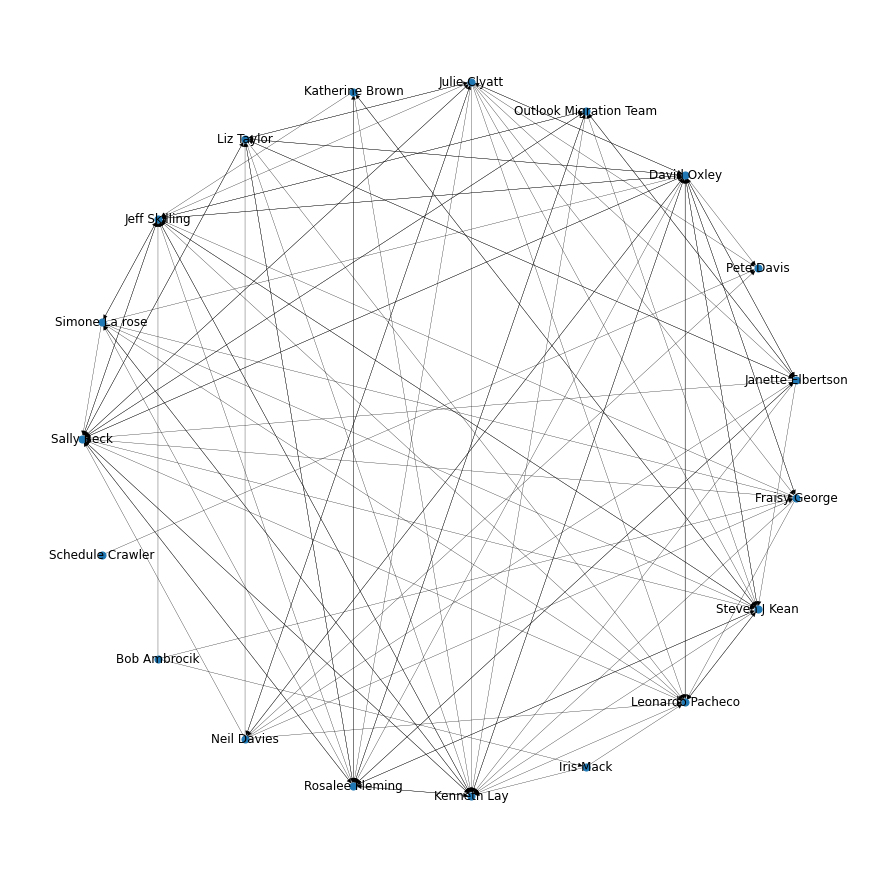

In [54]:
ideal = ['Leonardo Pacheco', 'Pete Davis', 'Liz Taylor', 'Julie Clyatt', 'Kenneth Lay', 'Sally Beck', 'Jeff Skilling', 'Fraisy George', 'Neil Davies', 'Steven J Kean', 'Rosalee Fleming', 'David Oxley', 'Outlook Migration Team', 'Schedule Crawler', 'Bob Ambrocik', 'Janette Elbertson', 'Katherine Brown', 'Iris Mack', 'Simone La rose']

plt.figure(figsize=(12,12)) 
nx.draw_shell(G.subgraph(ideal), node_size=50, width=0.3, with_labels=True)
plt.show()

In [41]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], G[edge[0]][edge[1]]['weight']) for edge in G.edges]
removed_nodes = []
for i in range(5):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)

#     print(results[1])
    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

['mark.guzman@enron.com', 'bill.williams.III@enron.com', 'monika.causholli@enron.com', 'jbryson@enron.com', 'Geir.Solberg@enron.com', 'leaf.harasin@enron.com', 'Schedule Crawler', 'pete.davis@enron.com', 'bert.meyers@enron.com', 'ryan.slinger@enron.com', 'dporter3@enron.com']


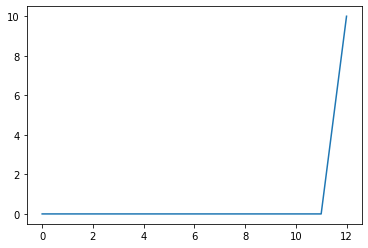

end of this subgraph
['Paul Kaufman', 'Mary Hain', 'vkaminski@aol.com', 'Sandra McCubbin', 'Harry Kingerski', 'Susan J Mara', 'Richard Shapiro', 'Karen Denne', 'Vince J Kaminski', 'James D Steffes', 'Joe Hartsoe', 'Janel Guerrero', 'Steven J Kean', 'Christi L Nicolay', 'Linda Robertson', 'Ginger Dernehl', 'Miyung Buster', 'Joseph Alamo', 'Sarah Novosel', 'Jeff Dasovich', 'Scott Govenar', 'Alan Comnes']


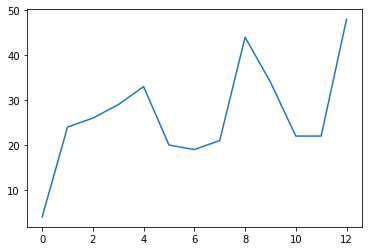

end of this subgraph
['Brent Hendry', 'Veronica Espinoza', 'Taffy Milligan', 'Pete Davis', 'Samantha Boyd', 'Bill Williams III', 'Susan Bailey', 'Mary Cook', 'Stephanie Panus', 'Tana Jones', 'Sara Shackleton', 'Ryan Slinger', 'Mark Taylor', 'Geir Solberg', 'Carol St Clair', 'Craig Dean', 'Marie Heard', 'Mark Guzman']


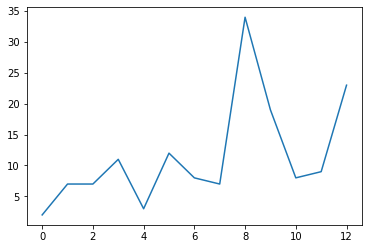

end of this subgraph
['Lorna Brennan', 'TK Lohman', 'Lindy Donoho', 'Kimberly Watson', 'Lorraine Lindberg', 'Steven Harris', 'Michelle Lokay', 'Kevin Hyatt', 'Jeffery Fawcett', 'Audrey Robertson', 'Susan Scott', 'Drew Fossum']


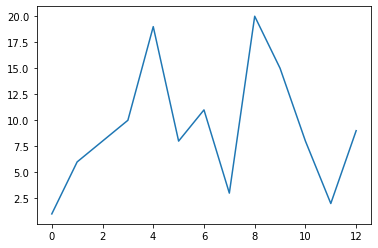

end of this subgraph
['Liz M Taylor', 'Lisa Burnett', 'Keith Holst', 'Eric Saibi', 'Terri Clynes', 'David Ryan', 'David Forster', 'Phillip K Allen', 'Russell Diamond', 'Jeffrey McMahon', 'Shona Wilson', 'Leonardo Pacheco', 'Bryan Hull', 'Kenny J Soignet', 'Russell Ballato', 'Sheila Tweed', 'Nicki Daw', 'Dean Laurent', 'Rudy Acevedo', 'All Enron Worldwide', 'Robert Benson', 'Liz Taylor', 'Don Baughman Jr.', 'Diana Allen', 'Cheryl Johnson', 'Andy Zipper', 'Julie Clyatt', 'Lloyd Will', 'Joannie Williamson', 'John Sherriff', 'Mitch Robinson', 'Rhonda L Denton', 'Kenneth Lay', 'Juan Padron', 'Mike Grigsby', 'Edward Sacks', 'Jeffrey T Hodge', 'Maria Valdes', 'Tom May', 'Elizabeth Sager', 'Sally Beck', 'Greg Whalley', 'Ina Rangel', 'Jennifer Burns', 'Larry Valderrama', 'Ben Jacoby', 'Kevin M. Presto', 'Matthew Lenhart', 'Benjamin Rogers', 'Don Baughman', 'Enron Announcements', 'Leslie Hansen', 'Tracy Ngo', 'Sharen Cason', 'Joe Stepenovitch', 'Kay Chapman', 'Larry Jester', 'Matt Lorenz', 'Mike

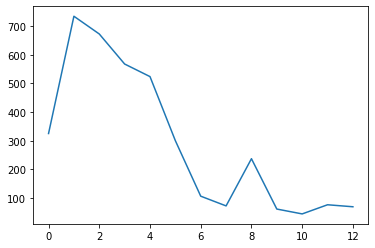

end of this subgraph


In [42]:
summary(removed_nodes, G, node_mapping)

In [43]:
pairs = [(node_mapping[edge[0]], node_mapping[edge[1]], 1) for edge in G.edges]
removed_nodes = []
for i in range(5):
    node_d, fibheap = init_heap_dict_weighted(pairs)
    results = peel_by_edge(node_d, fibheap, pairs, 1, log=False, log_interval=10000)

#     print(results[1])
    removed_nodes.append(results[1])

    new_pairs = []
    for pair in pairs:
        if pair[0] in results[1] or pair[1] in results[1]:
            continue
        else:
            new_pairs.append(pair)
    pairs = new_pairs

749
['Liz M Taylor', 'Parking & Transportation', 'Leslie Lawner', 'Frank Ermis', 'Jaime Williams', 'Jason R Williams', 'Theresa Zucha', 'Melba Lozano', 'Patti Sullivan', 'Steve Montovano', 'Keith Holst', 'Kathryn Sheppard', 'Lora Sullivan', 'Gerald Nemec', 'Gail Brownfeld', 'Susan M Landwehr', 'David Leboe', 'Brent Hendry', 'Jeffrey C. Gossett', 'Deb Korkmas', 'Paul Kaufman', 'Mary Hain', 'Robert Superty', 'Fran Chang', 'Maxine E Levingston', 'Stephanie J Harris', 'Greg Woulfe', 'Arfan Aziz', 'W. David Duran', 'Ruth Concannon', 'Veronica Espinoza', 'Kevin Hannon', 'Taffy Milligan', 'Ted C Bland', 'Aleck Dadson', 'John Shelk', 'Ed McMichael Jr.', 'Margo Reyna', 'David Forster', 'Sheila A Knudsen', 'Phillip K Allen', 'Donna Lowry', 'Mark - ECT Legal Taylor', 'Jeff Brown', 'Larry May', 'Kevin Ruscitti', 'Araceli Romero', 'Steven Kean', 'Debra Davidson', 'Shirley Tijerina', 'Russell Diamond', 'Jeffrey McMahon', 'Sandra McCubbin', 'John Llodra', 'Shona Wilson', 'Leonardo Pacheco', 'Bryan Hu

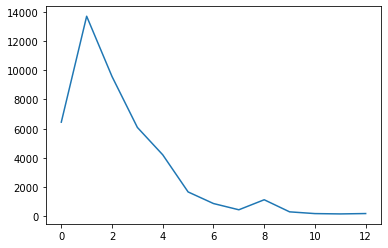

end of this subgraph
345
['eklinkner@ci.pasadena.ca.us', 'Mansoor Abdmoulaie', 'Jo Williams', 'Julia White', 'John Dushinske', 'salleyoo@dwt.com', 'bjeider@ci.burbank.ca.us', 'Arnie Bailey', 'Hayley Goodson', 'Sheila Nacey', "Paul Y'barbo", 'Norman A. Pedersen', 'Salle Yoo', 'Mark McConnell', 'Darrell Schoolcraft', 'Pilar Ramirez', 'pjpowerlaw@aol.com', 'Ranelle Paladino', 'rmp@cpuc.ca.gov', 'Terry Kowalke', 'Steve Hotte', 'Mark C Moench', 'Mae Dyson', 'Nancy Bagot', 'Jean Blair', 'Don Powell', 'Donna Martens', 'Theresa Branney', 'Fran Fagan', 'ETS Solution Center', 'Deb Cappiello', 'karen@klindh.com', 'Lynn Blair', 'Susan Wadle', 'Ron Matthews', 'tdickers@westerngas.com', 'marcel@turn.org', 'Mary Kay Miller', 'John Sturn', 'Dave Neubauer', 'Mann', 'rgloistein@orrick.com', 'Robert Kilmer III', 'Sherry Forbish', 'chris.king@utility.com', 'Blair Lichtenwalter', 'Bob Burleson', 'Gina Taylor', 'sscott3@enron.com', 'Steve Kirk', 'Joe Linhart', 'napedersen@jonesday.com', 'kmills@cfbf.com', '

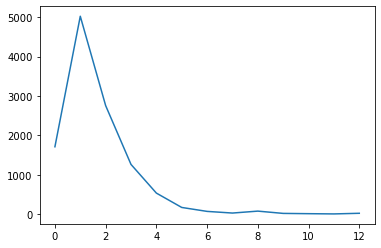

end of this subgraph
67
['Jaesoo Lew', 'Dupont', 'Alex', 'Sandeep Kohli', 'Tom Halliburton', 'Stinson Gibner', 'Paulo Issler', 'Tom Barkley', 'Clayton Vernon', 'Kevin G.', 'Viacheslav Danilov', 'Roman Zadorozhny', 'Shane Green', 'William Smith', 'Nelson Neale', 'Anne', 'Wichai Narongwanich', 'Joseph Hrgovcic', 'Zimin Lu', 'Kevin Kindall', 'Kevin G Moore', 'Shirley', 'Mike A. Roberts', 'Kenneth Parkhill', 'Osman Sezgen', 'Mitra Mujica', 'Mike A Roberts', 'Lucas', 'Therese Candella', 'Anjam Ahmad', 'Amitava Dhar', 'Moore', 'Kaminski', 'Youyi Feng', 'Anita Dupont', 'Anita', 'Alex Huang', 'Crenshaw', 'Vasant Shanbhogue', 'Sofya Tamarchenko', 'Praveen Mellacheruvu', 'Pinnamaneni Krishnarao', 'Anita DuPont', 'Rakesh Bharati', 'Shalesh Ganjoo', 'Lance Cunningham', 'Stephen Bennett', 'Huang', 'Martin Lin', 'Gwyn Koepke', 'Tanya Tamarchenko', 'Jason Sokolov', 'Seksan Kiatsupaibul', 'Elena Chilkina', 'Leann Walton', 'Kevin G. Moore', 'Jose Marquez', 'Chonawee Supatgiat', 'Martina Angelova', 'Rab

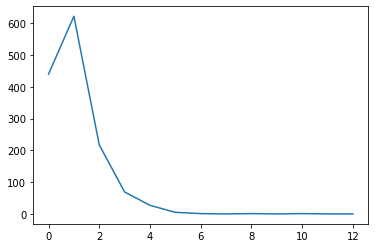

end of this subgraph
285
['Jennifer Bagwell', 'Elsa Villarreal', 'Sabrae Zajac', 'Susan Trevino', 'Marty McFadden', 'Greg Blue', 'Kristine Best', 'Israel Estrada', 'Constance Charles', 'Irena D Hogan', 'Katherine Herrera', 'Amanda Schultz', 'Edward Brady', 'Yvette G Connevey', 'Sachin Gandhi', 'Mark McCoy', 'Clem Cernosek', 'Kenny J Soignet', 'David Dupre', 'Amanda Huble', 'Michael Walters', 'Victor Guggenheim', 'Souad Mahmassani', 'Mary M Smith', 'Charlotte Hawkins', 'Susan McCabe', 'William Hall', "Justin O'Malley", 'Julee Ball', 'Donald P Reinhardt', 'Esther Buckley', 'Michael E. Moscoso', 'Sanjeev Gupta', 'Alyse Herasimchuk', 'William Kelly', 'Victoria Versen', 'Eddie Janzen', 'Kristen J Hanson', 'Ganapathy Ramesh', 'Andy Brown', 'Randy Bhatia', 'Lexi Elliott', 'Alex Saldana', 'Bill Carlson', 'Shari Mao', 'Theresa Staab', 'Jason Jones', 'Chuck Ames', 'Sean Boyle', 'Kimberly Vaughn', 'Bob Escalante', 'Jana Giovannini', 'Yan Wang', 'Beth A Ryan', 'Adrial Boals', 'Jason Williams', 'Ky

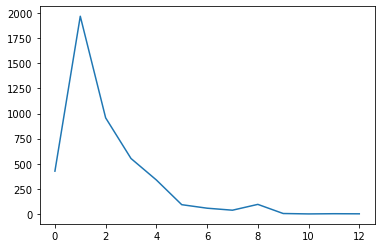

end of this subgraph
112
['cub@teleport.com', 'kevin.clark@ci.seattle.wa.us', 'townsend@chbh.com', 'Linc Wolverton', 'Jan Brooker', 'eauverde@hotmail.com', 'johncameron@dwt.com', 'Steve Marshall', 'pobenchain@idahopower.com', 'peter@richardsonandoleary.com', 'Bill Ferranti', 'marss@perkinscoie.com', 'rbstrong@painehamblen.com', 'tdeboer@painehamblen.com', 'scott.brattebo@pacificorp.com', 'michaelearly@earthlink.net', 'marc.hellman@state.or.us', 'Eric.Larson@oremetwahchang.com', 'huse@eesconsulting.com', 'Terry Mundorf', 'elisaCKF@aol.com', 'pljacklin@stoel.com', 'johk@critfc.org', 'pvickery@tpud.org', 'Kerry McElroy', 'matts1@atg.wa.gov', 'jpw@duncanallen.com', 'pete@ashland.or.us', 'jdeason@chbh.com', 'mershanlaw@aol.com', 'Sarah Westenberg', 'KBeniga@SCHWABE.com', 'bessex@cowlitzpud.org', 'Lincoln  Wolverton', 'Peter J - LP-7 Burger', 'skaravit@ci.tacoma.wa.us', 'sjohnsto@wutc.wa.gov', 'ccopatrny@e-z.net', 'rle@givenspursley.com', 'mike.macdougall@powerex.com', 'lyn_williams@pgn.com'

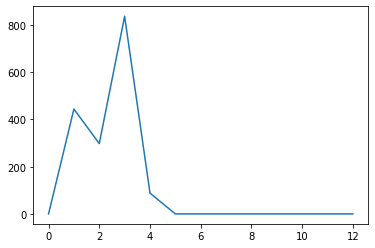

end of this subgraph


In [46]:
summary(removed_nodes, G, node_mapping)